**Goal:** 
To evaluate a learned Bayesian Network (BN) on AMIB positive-affect data using:
  1) Bayesian Inference Criterion (BIC)
  2) Akaike Information Criterion (AIC)

After that, we will be using other evaluation methods and interpret the results

**Install Libraries**

In [1]:
# ---------------------------------------------------------------
# Install required libraries
# ---------------------------------------------------------------
!pip install pandas numpy scipy pgmpy

In [48]:
# ---------------------------------------------------------------
# Import libraries
# ---------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skew, kurtosis, trim_mean
from statsmodels.robust.scale import mad as sm_mad
from scipy.stats import pearsonr
from pgmpy.estimators import PC

**1. Load AMIB data**

In [49]:
# ---------------------------------------------------------------
# STEP 1 - Load AMIB daily data
# ---------------------------------------------------------------

df = pd.read_csv("wine.csv")
new_df = df.columns.tolist()
print(new_df)


['fixedacidity', 'volatileacidity', 'citricacid', 'residualsugar', 'chlorides', 'freesulfurdioxide', 'totalsulfurdioxide', 'density', 'ph', 'sulphates', 'alcohol', 'quality']


**2. Describe the variables of interest in the AMIB data**

In [52]:
# ---------------------------------------------------------------
# STEP 2 - Select positive affect variables
# ---------------------------------------------------------------

var_pos = [
    "fixedacidity", "volatileacidity", "citricacid", "residualsugar", "chlorides",
    "freesulfurdioxide", "totalsulfurdioxide", "density", "ph", "sulphates", "alcohol", "quality"
]
df_cc = df[var_pos].dropna(axis=0, how="any").copy()

**3. Learn Network**

In [53]:
# ---------------------------------------------------------------
# STEP 3 — Learn the Bayesian network with PC 
# ---------------------------------------------------------------
import numpy as np
from pgmpy.estimators import PC

# set your selections here
CI_TEST = 'pearsonr'   ##### Insert "pearsonr" #######
ALPHA   =  0.05    ##### Insert 0.05       #######   

data_num = pos_affect_data.apply(pd.to_numeric, errors="coerce")
pc_input = data_num.dropna(axis=0, how="any").copy()

# optional normalization to stabilize correlations (kept minimal)
pc_input = (pc_input - pc_input.mean()) / pc_input.std(ddof=0)

# Learn structure: PC (Stable) + selected CI test
pc = PC(pc_input)

# try to raise the conditioning-set cap if your pgmpy version supports it;
# otherwise silently fall back to default (keeps your structure & output)
try:
    dag = pc.estimate(
        variant="stable",
        ci_test=CI_TEST,            # <- your selected CI test
        significance_level=ALPHA,   # <- your selected alpha
        return_type="dag",
        max_cond_vars=10,            # may be unsupported on some versions
        show_progress=False
    )
except TypeError:
    # fallback without extras if this pgmpy version doesn't accept them
    dag = pc.estimate(
        variant="stable",
        ci_test=CI_TEST,
        significance_level=ALPHA,
        return_type="dag"
    )

# bnlearn-like summary 
nodes = list(dag.nodes())
edges = list(dag.edges())

# neighbourhood sizes
neighbors = {n: set(dag.predecessors(n)) | set(dag.successors(n)) for n in nodes}

# markov blanket sizes (parents ∪ children ∪ co-parents of children)
mb_sizes = []
for n in nodes:
    parents = set(dag.predecessors(n))
    children = set(dag.successors(n))
    spouses = set().union(*[set(dag.predecessors(c)) for c in children]) if children else set()
    mb = (parents | children | spouses) - {n}
    mb_sizes.append(len(mb))

avg_mb = float(np.mean(mb_sizes)) if mb_sizes else 0.0
avg_nei = float(np.mean([len(neighbors[n]) for n in nodes])) if nodes else 0.0
avg_branch = float(np.mean([len(list(dag.successors(n))) for n in nodes])) if nodes else 0.0

print("\nBayesian network learned via Constraint-based methods\n")
print("model (DAG edges):")
for u, v in edges:
    print(f"  {u} -> {v}")

print(f"\n  nodes:                                 {len(nodes)}")
print(f"  arcs:                                  {len(edges)}")
print(f"    undirected arcs:                     0")
print(f"    directed arcs:                       {len(edges)}")
print(f"  average markov blanket size:           {avg_mb:.2f}")
print(f"  average neighbourhood size:            {avg_nei:.2f}")
print(f"  average branching factor:              {avg_branch:.2f}\n")
print("  learning algorithm:                    PC (Stable)")
print(f"  conditional independence test:         {CI_TEST}")
print(f"  alpha threshold:                       {ALPHA}")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fixedacidity': 'N', 'volatileacidity': 'N', 'citricacid': 'N', 'residualsugar': 'N', 'chlorides': 'N', 'freesulfurdioxide': 'N', 'totalsulfurdioxide': 'N', 'density': 'N', 'ph': 'N', 'sulphates': 'N', 'alcohol': 'N', 'quality': 'N'}
INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting



Bayesian network learned via Constraint-based methods

model (DAG edges):
  totalsulfurdioxide -> freesulfurdioxide
  totalsulfurdioxide -> density
  alcohol -> quality
  fixedacidity -> quality
  fixedacidity -> citricacid
  volatileacidity -> chlorides
  residualsugar -> ph

  nodes:                                 12
  arcs:                                  7
    undirected arcs:                     0
    directed arcs:                       7
  average markov blanket size:           1.33
  average neighbourhood size:            1.17
  average branching factor:              0.58

  learning algorithm:                    PC (Stable)
  conditional independence test:         pearsonr
  alpha threshold:                       0.05


**4. Visualize Bayesian Network**

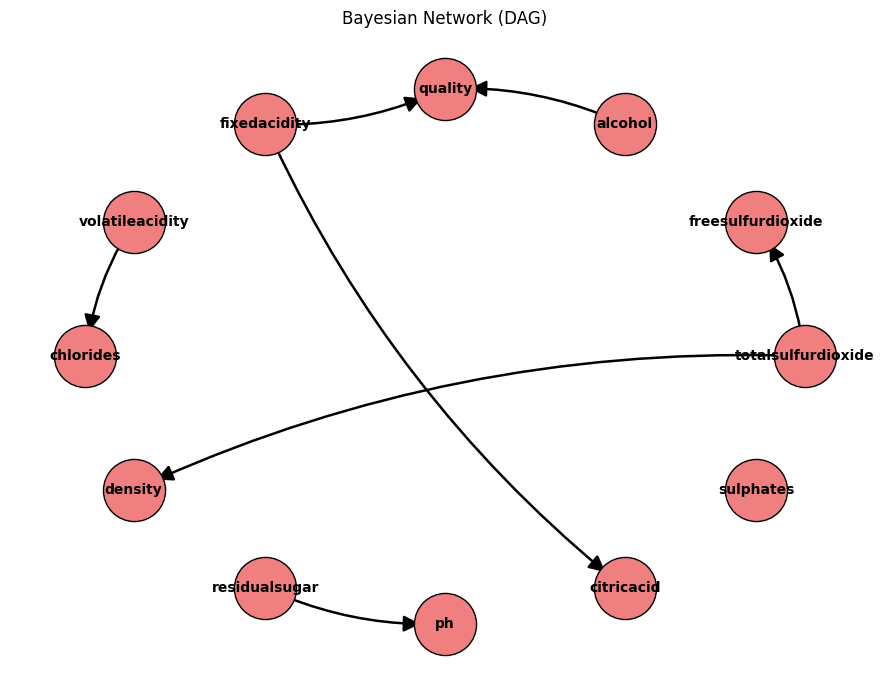

In [54]:
# ---------------------------------------------------------------
# STEP 4 - Visualization of Bayesian Network
# ---------------------------------------------------------------
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def _safe_layout(G):
    # Try a stable layout; fall back if anything non-finite appears
    pos = nx.spring_layout(G, seed=7, k=0.9)
    ok = all(np.isfinite(x) and np.isfinite(y) for x, y in pos.values())
    if not ok or len(pos) != len(G.nodes()):
        pos = nx.circular_layout(G)
    return pos

def plot_bn_dag_quiver(G, title="Bayesian Network (DAG)"):
    H = nx.DiGraph(G)
    if H.number_of_nodes() == 0:
        print("Graph is empty.")
        return

    pos = _safe_layout(H)

    plt.figure(figsize=(9, 7))
    # Nodes & labels
    nx.draw_networkx_nodes(H, pos, node_size=2000, node_color="#F08080", edgecolors="black")
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold")

    # Draw edges as simple lines (no arrows to avoid FancyArrowPatch bug)
    nx.draw_networkx_edges(H, pos, arrows=True, arrowstyle='-|>', arrowsize=24, width=1.8,
        connectionstyle='arc3,rad=0.12',  # slight curve so edges don't overlap
        min_source_margin=18,  # keep heads off nodes
        min_target_margin=18)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


plot_bn_dag_quiver(dag)


**5. Evaluation of Bayesian Network**

Full-model BIC: -44259.584
Top edges by ΔBIC:
alcohol -> quality: ΔBIC = 438.824
totalsulfurdioxide -> freesulfurdioxide: ΔBIC = 191.791
totalsulfurdioxide -> density: ΔBIC = 174.677
fixedacidity -> citricacid: ΔBIC = 95.835
residualsugar -> ph: ΔBIC = 32.993
fixedacidity -> quality: ΔBIC = 10.837
volatileacidity -> chlorides: ΔBIC = 9.374


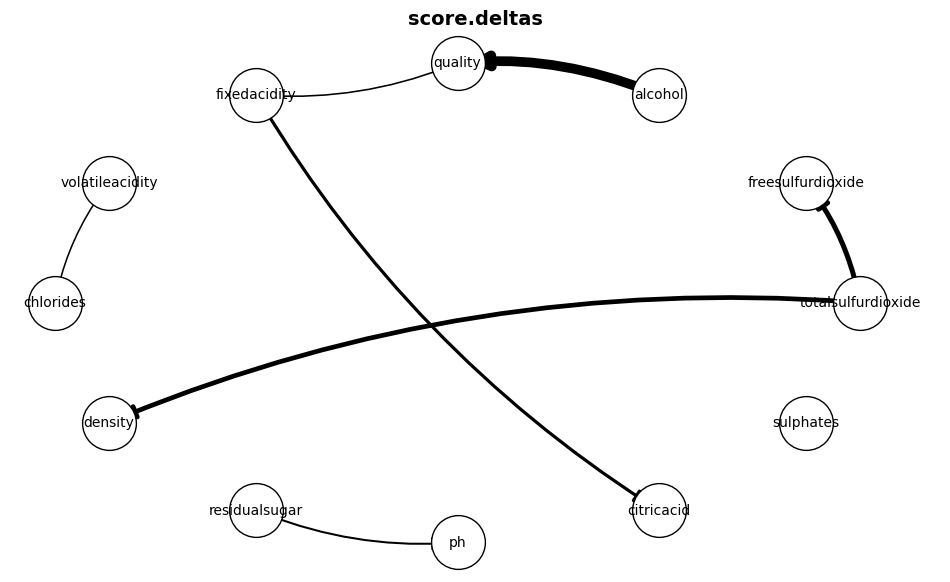

In [70]:
# ============================================
#  Step 5(a) - Bayesian Information Criterion (BIC)
# ============================================
import numpy as np, math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1) complete cases (like na.omit)
var_pos = [
    "fixedacidity", "volatileacidity", "citricacid", "residualsugar", "chlorides",
    "freesulfurdioxide", "totalsulfurdioxide", "density", "ph", "sulphates", "alcohol", "quality"
]
df_cc = df[var_pos].dropna(axis=0, how="any").copy()
n = len(df)
if n == 0:
    raise ValueError("No complete cases available; cannot compute BIC.")

# 2) linear-Gaussian node BIC (bnlearn bic-g: maximize ll - 0.5*k*log n)
def node_bic(y, X):
    n = y.shape[0]
    if X is None or X.size == 0:
        mu = y.mean()
        resid = y - mu
        s2 = max(float(np.dot(resid, resid) / n), 1e-12)   # MLE variance
        ll = -0.5 * n * (math.log(2*math.pi*s2) + 1)
        k = 2  # intercept + variance
        return ll - 0.5 * k * math.log(n)
    X_ = np.column_stack([np.ones(n), X])
    beta, *_ = np.linalg.lstsq(X_, y, rcond=None)
    resid = y - X_.dot(beta)
    s2 = max(float(np.dot(resid, resid) / n), 1e-12)
    ll = -0.5 * n * (math.log(2*math.pi*s2) + 1)
    k = X_.shape[1] + 1  # (coeffs incl intercept) + variance
    return ll - 0.5 * k * math.log(n)

def model_bic(dag, df):
    total = 0.0
    for node in dag.nodes():
        parents = list(dag.get_parents(node))
        y = df[node].to_numpy(float)
        X = None if not parents else df[parents].to_numpy(float)
        total += node_bic(y, X)
    return total

# 3) ΔBIC per edge: base − without-edge
base_bic = model_bic(dag, df)
edge_delta = {}
for u, v in dag.edges():
    g2 = dag.copy()
    g2.remove_edge(u, v)
    edge_delta[(u, v)] = base_bic - model_bic(g2, df)

# Full-model AIC
full_model_bic = model_bic(dag, df_cc)
print(f"Full-model BIC: {full_model_bic:.3f}")

# (Optional) inspect strongest edges
ranked = sorted(edge_delta.items(), key=lambda kv: kv[1], reverse=True)
print("Top edges by ΔBIC:")
for (u, v), d in ranked[:10]:
    print(f"{u} -> {v}: ΔBIC = {d:.3f}")

# 4) Inline strength plot (no saving)
def strength_plot(dag, edge_delta, layout="kamada_kawai", title="score.deltas"):
    # positions
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(dag)
    else:
        pos = nx.spring_layout(dag, seed=7, k=1.2, iterations=300)

    # node style (like bnlearn)
    plt.figure(figsize=(12,7))
    nx.draw_networkx_nodes(dag, pos, node_color="white", node_size=1500, edgecolors="black")
    nx.draw_networkx_labels(dag, pos, font_size=10, font_color="black")

    # scale widths; dashed for non-positive
    if len(edge_delta):
        maxd = max(edge_delta.values())
        maxd = max(maxd, 1e-9)
    else:
        maxd = 1.0

    for (u, v) in dag.edges():
        d = edge_delta.get((u, v), 0.0)
        width = 1.0 + 6.0 * max(d, 0.0) / maxd   # 1..7
        style = "solid" if d > 0 else "dashed"
        nx.draw_networkx_edges(
            dag, pos, edgelist=[(u, v)],
            arrows=True, arrowstyle='-|>', arrowsize=20,
            width=width, style=style, edge_color="black",
            connectionstyle='arc3,rad=0.12'
        )

    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.show()

strength_plot(dag, edge_delta, layout="kamada_kawai", title="score.deltas")


Full-model AIC: -44158.887
Top edges by ΔAIC:
alcohol -> quality: ΔAIC = 442.073
totalsulfurdioxide -> freesulfurdioxide: ΔAIC = 195.039
totalsulfurdioxide -> density: ΔAIC = 177.925
fixedacidity -> citricacid: ΔAIC = 99.083
residualsugar -> ph: ΔAIC = 36.241
fixedacidity -> quality: ΔAIC = 14.085
volatileacidity -> chlorides: ΔAIC = 12.622


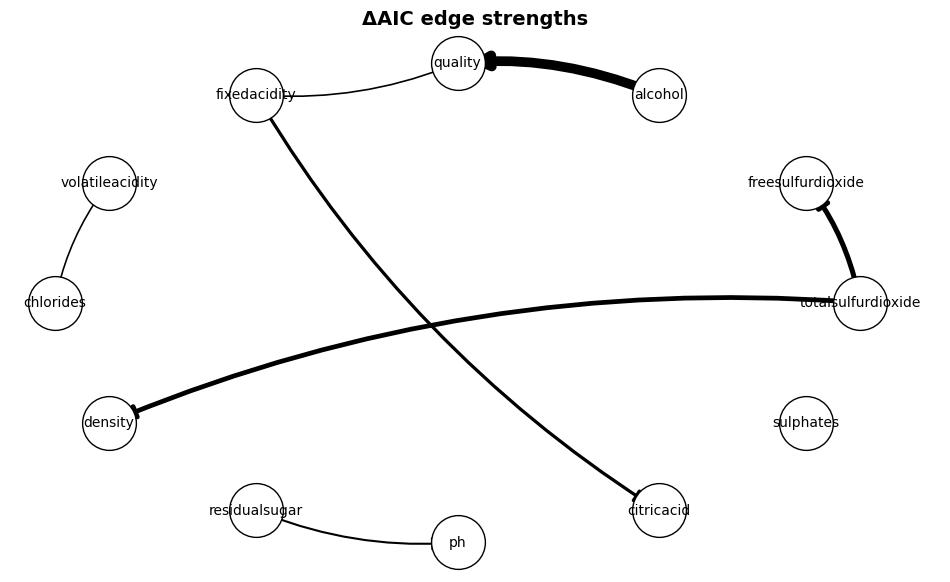

In [68]:
# ============================================
#  Step 5(b) - Akaike Information Criterion (AIC)
# ============================================
import numpy as np, math
import matplotlib.pyplot as plt
import networkx as nx

def node_aic(y, X):
    n = y.shape[0]
    if X is None or X.size == 0:
        mu = y.mean()
        resid = y - mu
        s2 = max(float(np.dot(resid, resid) / n), 1e-12)
        ll = -0.5 * n * (math.log(2 * math.pi * s2) + 1)
        k = 2  # intercept + variance
        return ll - k
    X_ = np.column_stack([np.ones(n), X])
    beta, *_ = np.linalg.lstsq(X_, y, rcond=None)
    resid = y - X_.dot(beta)
    s2 = max(float(np.dot(resid, resid) / n), 1e-12)
    ll = -0.5 * n * (math.log(2 * math.pi * s2) + 1)
    k = X_.shape[1] + 1
    return ll - k

def model_aic(dag, df_cc):
    total = 0.0
    for node in dag.nodes():
        parents = list(dag.get_parents(node))
        y = df[node].to_numpy(float)
        X = None if not parents else df[parents].to_numpy(float)
        total += node_aic(y, X)
    return total

# compute ΔAIC per edge
base_aic = model_aic(dag, df_cc)
edge_delta_aic = {}
for u, v in dag.edges():
    g2 = dag.copy()
    g2.remove_edge(u, v)
    edge_delta_aic[(u, v)] = base_aic - model_aic(g2, df_cc)
    
# Full-model AIC
full_model_aic = model_aic(dag, df_cc)
print(f"Full-model AIC: {full_model_aic:.3f}")

# sort edges by ΔAIC
ranked_aic = sorted(edge_delta_aic.items(), key=lambda kv: kv[1], reverse=True)
print("Top edges by ΔAIC:")
for (u, v), d in ranked_aic[:10]:
    print(f"{u} -> {v}: ΔAIC = {d:.3f}")

# visualize (reuse same plotting function)
strength_plot(dag, edge_delta_aic, layout="kamada_kawai", title="ΔAIC edge strengths")


In [75]:
# ==============================================================================
# 5(c) K2 Score & Bayesian Dirichlet equivalence with uniform prior (BDeu)
# ==============================================================================
import pandas as pd
import numpy as np
import networkx as nx
from pgmpy.metrics import structure_score

# --- 0) pick variables (same as before)
var_pos = [
    "fixedacidity", "volatileacidity", "citricacid", "residualsugar", "chlorides",
    "freesulfurdioxide", "totalsulfurdioxide", "density", "ph", "sulphates", "alcohol", "quality"
]

# Use your existing dataframe df (already loaded)
df_cc = df[var_pos].dropna(axis=0, how="any").copy()

# --- 1) DISCRETIZE (quantile bins). Change q if you want more/less states.
Q = 3  # e.g., 3-level ordinal (low/med/high)
disc = pd.DataFrame(index=df_cc.index)
for col in vars_pos:
    # quantile bins; duplicate edges="drop" guards against ties
    disc[col] = pd.qcut(df_cc[col].rank(method="average"), q=Q, labels=range(Q), duplicates="drop")
# cast to int for discrete scoring
disc = disc.astype(int)

# --- 2) Whole-graph scores (your existing DAG learned on continuous data)
# Note: structure_score returns a scalar; higher is better.
k2_total   = structure_score(dag, disc, scoring_method="k2")
bdeu_total = structure_score(dag, disc, scoring_method="bdeu", equivalent_sample_size=10)

print(f"K2  (total):  {k2_total:.3f}")
#print(f"K2 (total): {k2_total:.3f}")
print(f"BDeu(total):  {bdeu_total:.3f}  (ESS=10)")
#print(f"BDeu(total): {bdeu_total:.3f} (ESS=10)")

# --- 3) Edge-wise Δ scores: Δ = score(full) - score(without edge)
def edge_deltas_discrete(G, data, method, **kwargs):
    base = structure_score(G, data, scoring_method=method, **kwargs)
    out = {}
    for u, v in G.edges():
        g2 = G.copy()
        g2.remove_edge(u, v)
        out[(u, v)] = base - structure_score(g2, data, scoring_method=method, **kwargs)
    return out

edge_delta_k2   = edge_deltas_discrete(dag, disc, "k2")
edge_delta_bdeu = edge_deltas_discrete(dag, disc, "bdeu", equivalent_sample_size=10)

# --- 4) Print top edges
def print_top(edge_delta, name, k=10):
    ranked = sorted(edge_delta.items(), key=lambda kv: kv[1], reverse=True)[:k]
    print(f"\nTop edges by Δ{name}:")
    for (u, v), d in ranked:
        print(f"{u} -> {v}: Δ{name} = {d:.3f}")
    return ranked

top_k2   = print_top(edge_delta_k2, "K2")
top_bdeu = print_top(edge_delta_bdeu, "BDeu")

# --- 5) Plot (reuses your existing strength_plot)
# If you have strength_plot from before, you can call it directly:
strength_plot(dag, edge_delta_k2,   layout="kamada_kawai", title="ΔK2 edge strengths")
strength_plot(dag, edge_delta_bdeu, layout="kamada_kawai", title="ΔBDeu edge strengths (ESS=10)")


KeyError: 'enthusiastic'